In [1]:
# class 
import random
import time
import astropy.wcs as wcs
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import match_coordinates_sky

class HSCdr2_cat_process():
    def __init__(self):
        return
    
    def get_data(self, fname, process=True, **run_hsc_clean_kwargs):
        print('read in data %s'%fname)
        df = pd.read_csv(fname)
        df.rename(columns={"# ra": "ra"}, inplace = True)
        if process:
            print('data preprocessing ...')
            df = self.data_preprocess(df)
            print('HSC catalog cleaning ...')
            df = self.run_hsc_clean(df, **run_hsc_clean_kwargs)
        return df
    
    def get_data_list(self, fname_list, process=True):
        df = pd.DataFrame()
        
        for fname in fname_list:
            dfi = pd.read_csv(fname)
            dfi.rename(columns={"# ra": "ra"}, inplace = True)
            df = pd.concat([df,dfi]).drop_duplicates(subset = 'ObjID')
        
        df = df.drop(['object_ID'], axis=1)
        if process:
            df = self.run_hsc_clean(df, verbose=True)
            df = self.data_preprocess(df)
        return df
        
    def data_preprocess(self, df_in):
        
        df = df_in.copy()
        
        # drop rows with no mag in all bands
        sp = np.all(np.isnan(df[['g_psfflux_mag','r_psfflux_mag','i_psfflux_mag',
                                 'z_psfflux_mag','y_psfflux_mag']]),axis=1)
        df = df.iloc[~sp]

        # set class to NaN if no mag in that band
        for band in ['g','r','i','z','y']:
            sp = np.isnan(df[band + '_psfflux_mag'])
            df[band + '_extendedness_value'].iloc[np.where(sp)[0]] = np.nan

        # get class
        cls_arr = np.zeros(len(df))
        sp = np.all(np.isnan(df[['g_extendedness_value','r_extendedness_value','i_extendedness_value',
                             'z_extendedness_value','y_extendedness_value']]),axis=1)
        cls_arr[sp] = 2
        
        cls = np.nanmean(df.iloc[~sp][['g_extendedness_value','r_extendedness_value','i_extendedness_value',
                             'z_extendedness_value','y_extendedness_value']], axis=1)
        cls[cls < 0.5] = -1
        cls[cls > 0.5] = 1
        cls[cls == 0.5] = 2
        
        cls_arr[~sp] = cls
        df['cls'] = cls_arr

        df = df.drop(['g_extendedness_value','r_extendedness_value','i_extendedness_value',
                             'z_extendedness_value','y_extendedness_value'], axis=1)

        df = df.fillna(-99)
        df = df.replace(np.inf,-99)
        df = df.replace(-np.inf,-99)
        df = df.reset_index(drop=True)
        df.index += 1
        
        return df
        
    def run_hsc_clean(self, df_in, subreg=9, verbose=False):
        df = df_in.copy()
        df_clean = pd.DataFrame()
        ra_lims = np.linspace(min(df['ra']),max(df['ra']),subreg)
        dec_lims = np.linspace(min(df['dec']),max(df['dec']),subreg)
        for ira,(ra1,ra2) in enumerate(zip(ra_lims[:-1],ra_lims[1:])):
            for idec,(dec1,dec2) in enumerate(zip(dec_lims[:-1],dec_lims[1:])):
                if verbose:
                    print("cleaning region (%d,%d)"%(ira,idec))
                dfs = df[(df['ra']>=ra1) & (df['ra']<ra2) & (df['dec']>=dec1) & (df['dec']<dec2)]
                dfs = self.clean_hsc(dfs,verbose=verbose)
                df_clean = df_clean.append(dfs)
                
        df_clean = df_clean.reset_index(drop=True)
        return df_clean
    
    def clean_hsc(self, df_in, verbose=False):
        df = df_in.copy()
        df = df.replace(-99,np.nan)
        start_time = time.time()
        ra_arr = np.array(df['ra'])*3600
        dec_arr = np.array(df['dec'])*3600
        Nnan_arr = np.array(df.isnull().sum(axis=1))
        idx_arr = np.arange(len(df))
        idx_use = []
        while len(idx_arr) > 0:
            idxi = idx_arr[0]
            sp = np.where((abs(ra_arr[0] - ra_arr)<0.2) & (abs(dec_arr[0] - dec_arr)<0.1))[0]
            if len(sp)==0:
                sp = np.array([0])
            idxs = idx_arr[sp]
            ras = ra_arr[sp]
            decs = dec_arr[sp]
            decrads = decs/3600/180*np.pi
            ds = np.sqrt(((ras[0]-ras)*np.cos((decrads[0]+decrads)/2))**2 + (decs[0] - decs)**2)
            sp1 = np.where(ds<0.1)[0]
            idxs = idxs[sp1]
            if len(idxs) == 1:
                idx_use.append(int(idxs))
            else:
                idx_use.append(idxs[np.argmin(Nnan_arr[sp[sp1]])])

            idx_arr = np.delete(idx_arr,sp[sp1])
            ra_arr = np.delete(ra_arr,sp[sp1])
            dec_arr = np.delete(dec_arr,sp[sp1])
            Nnan_arr = np.delete(Nnan_arr,sp[sp1])
        df = df.fillna(-99)
        if verbose:
            print('cleaning df (%d -> %d), time = %.2f min'%\
                  (len(df),len(idx_use),(time.time()-start_time)/60))
        return df.iloc[idx_use]
    
    def write_lePHARE_input(self, df, fname):
        df_lph = df[['g_psfflux_mag','g_psfflux_magsigma','r_psfflux_mag','r_psfflux_magsigma',
                        'i_psfflux_mag','i_psfflux_magsigma','z_psfflux_mag','z_psfflux_magsigma',
                        'y_psfflux_mag','z_psfflux_magsigma']].copy()
        df_lph['Imag'] = np.ones(len(df_lph))*-99
        df_lph['Imag_err'] = np.ones(len(df_lph))*-99
        df_lph['Hmag'] = np.ones(len(df_lph))*-99
        df_lph['Hmag_err'] = np.ones(len(df_lph))*-99
        
        df_lph.to_csv(fname, sep=' ', header=False, float_format='%.3e') 
        return
    
    def process_lePHARE_output(self, df_in, fname):
        df = df_in.copy()
        names = ['id' , 'z_b' , 'z_b68l' , 'z_b68h' ,'z_ml','CHI_BEST','MOD_BEST','NBAND_USED',
                 'Z_QSO' , 'CHI_QSO' , 'MOD_QSO' , 'MOD_STAR' , 'CHI_STAR', 
                 'gmag_mod', 'rmag_mod','imag_mod','zmag_mod','ymag_mod','Imag_mod','Hmag_mod']
        df_out = pd.read_csv(fname,sep='\s+',index_col=0,names = names,skiprows=53)
        df_out.drop(['MOD_BEST','MOD_STAR','MOD_QSO'], inplace=True, axis=1)
        cls = np.argmin(np.array(df_out[['CHI_STAR','CHI_BEST','CHI_QSO']]),axis=1)
        cls[cls==0] = -1
        df_out['cls'] = cls

        df['cls_leph'] = df_out['cls']
        photz = df_out['z_b'].values
        photz[df['cls_leph']==-1] = -99
        df['photz_leph'] = photz

        df['Imag'] = np.array(df_out['Imag_mod'])
        df['Hmag'] = np.array(df_out['Hmag_mod'])
        mags = df[['g_psfflux_mag','r_psfflux_mag','i_psfflux_mag','z_psfflux_mag','y_psfflux_mag']]
        mags = mags.replace(-99, np.nan)
        mags_exist = ~pd.isnull(mags)*1
        mags = np.array(mags)
        mags_exist = np.array(mags_exist)
        mag_vec = np.zeros(mags.shape[0])
        for i in range(mags.shape[0]):
            idxs = np.where(mags_exist[i,:]==1)[0]
            if len(idxs)==0:
                mag_vec[i] = 99
            else:
                mag_vec[i] = mags[i,idxs[-1]]

        magI_arr = np.array(df_out['Imag_mod'])
        magI_arr[magI_arr==-99.99] = mag_vec[magI_arr==-99.99]
        magI_arr[((mag_vec-magI_arr)>5)&(magI_arr<20)] = mag_vec[((mag_vec-magI_arr)>5)&(magI_arr<20)]
        df['Imag'] = magI_arr

        magH_arr = np.array(df_out['Hmag_mod'])
        magH_arr[magH_arr==-99.99] = mag_vec[magH_arr==-99.99]
        magH_arr[((mag_vec-magH_arr)>5)&(magH_arr<20)] = mag_vec[((mag_vec-magH_arr)>5)&(magH_arr<20)]
        df['Hmag'] = magH_arr

        df = df.drop(['g_psfflux_magsigma','r_psfflux_magsigma','i_psfflux_magsigma',
                     'z_psfflux_magsigma','y_psfflux_magsigma'], axis=1)

        df.rename(columns={"g_psfflux_mag": "gmag","r_psfflux_mag": "rmag",
                           "i_psfflux_mag": "imag","z_psfflux_mag": "zmag",
                           "y_psfflux_mag": "ymag"}, inplace = True)
        df = df[['ra','dec','x','y','gmag','rmag','imag','zmag','ymag','Imag','Hmag',
                 'cls','cls_leph','photz_leph']]
        return df

    def write_xycoords(self, df_in, ra_cent, dec_cent):
        df = df_in.copy()
        thx = (df['ra']-ra_cent)*np.cos(df['dec']*np.pi/180)
        thy = df['dec']-dec_cent
        df['x'] = thx
        df['y'] = thy
        return df
    
    def write_processed_df(self,df,fname):
        df.to_csv(fname,index=False,float_format='%.6e')
        return


In [ ]:
# process data, write lePHARE input

# for fieldname in ['W05_0', 'W05_1', 'W05_2', 'W05_3']:
#     fname = '/Volumes/Drive/ciber/data/HSC/raw/' + fieldname + '.csv'
#     df = HSCdr2_cat_process().get_data(fname,verbose=True,subreg=60)

#     fig = plt.figure(figsize=(21,3))
#     plt.scatter(df['ra'][(df['g_psfflux_mag']<24) & (df['g_psfflux_mag']!=-99)],
#                 df['dec'][(df['g_psfflux_mag']<24)& (df['g_psfflux_mag']!=-99)], s=0.002)
#     plt.title(fname)

#     fname = '/Volumes/Drive/ciber/data/HSC/lePHARE/' + fieldname + '.in'
#     HSCdr2_cat_process().write_lePHARE_input(df, fname)
#     df = HSCdr2_cat_process().write_xycoords(df, 337, 0)
#     fname = '/Volumes/Drive/ciber/data/HSC/processed/' + fieldname + '.csv'
#     HSCdr2_cat_process().write_processed_df(df, fname)

In [9]:
reglim = {}
regcount = 0
for x in np.arange(-5.2,6.8,2):
    for y in np.arange(-0.5,3.5,2):
        reglim[regcount]=(x,x+2,y,y+2)
        regcount += 1
for ireg in range(regcount):
    xmin,xmax,ymin,ymax = reglim[ireg]
    df = pd.DataFrame()
    for i in range(4):
        fieldname = 'W05_' + str(i)
        fname = '/Volumes/Drive/ciber/data/HSC/processed/' + fieldname + '.csv'
        dfi = pd.read_csv(fname)
        fname = '/Volumes/Drive/ciber/data/HSC/lePHARE/' + fieldname + '.out'
        dfi = HSCdr2_cat_process().process_lePHARE_output(dfi, fname)
        dfi = dfi.loc[(dfi['x']>xmin) & (dfi['x']<xmax) & (dfi['y']>ymin) & (dfi['y']<ymax)]
        df = pd.concat([df,dfi])
        print('reg%d, %s, %.2e sources'%(ireg, fieldname, len(dfi)))
    df = df.reset_index(drop=True)
    df['x'] = (df['x'] - xmin)*3600/7
    df['y'] = (df['y'] - ymin)*3600/7
    fname = '/Volumes/Drive/ciber/data/HSC/fields/W05_' + str(ireg) + '.csv'
    HSCdr2_cat_process().write_processed_df(df, fname)
    print(np.min(df['x']),np.min(df['y']),np.max(df['x']),np.max(df['y']))    

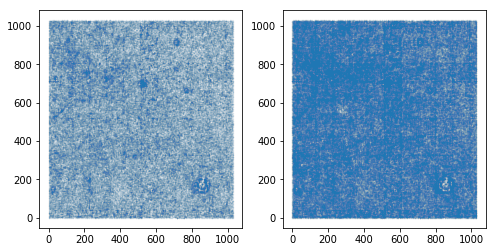

In [10]:
fig, ax = plt.subplots(1,2,figsize=(8,4))
ax[0].scatter(df['x'][(df['Imag']<24)],df['y'][(df['Imag']<24)], s=0.0002)
ax[1].scatter(df['x'][(df['Hmag']<24)],df['y'][(df['Hmag']<24)], s=0.0002)

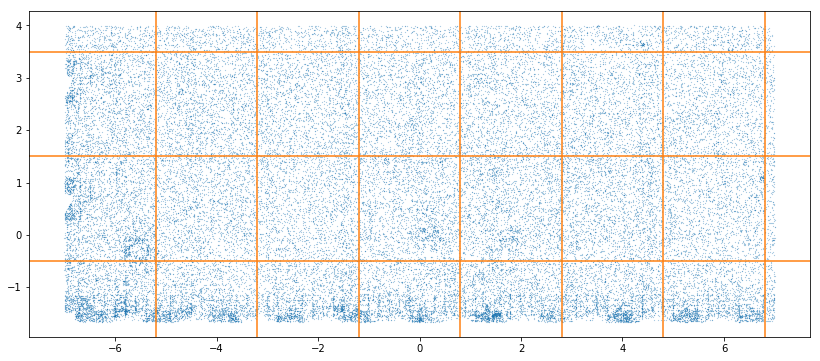

In [20]:
fig = plt.figure(figsize=(14,6))
plt.scatter(df['x'][(df['gmag']<24) & (df['x']!=-99)],
            df['y'][(df['gmag']<24)& (df['y']!=-99)], s=0.02)
for x in np.arange(-5.2,6.8+1,2):
    plt.axvline(x,c='C1')
for y in np.arange(-0.5,3.5+1,2):
    plt.axhline(y,c='C1')